<a href="https://colab.research.google.com/github/zhangtaorex/JAXMDZT/blob/main/notebooks/tutorial/Chapter_2_Physical_Quantities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Computing physical quantities

In [1]:
#@title Imports and Definitions

#!pip install jax-md
!pip install -q git+https://www.github.com/google/jax-md

import numpy as onp

import jax.numpy as jnp
from jax import config
config.update('jax_enable_x64', True)

from jax import random
from jax import jit, lax, grad, vmap, hessian
import jax.scipy as jsp

from jax_md import space, energy, smap, simulate, minimize, util, elasticity, quantity, partition
from jax_md.colab_tools import renderer

f32 = jnp.float32
f64 = jnp.float64

from functools import partial

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

def format_plot(x, y):
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 0.7)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])

def run_minimization_while(energy_fn, R_init, shift, max_grad_thresh = 1e-12, max_num_steps=1000000, **kwargs):
  init, apply=minimize.fire_descent(jit(energy_fn), shift, **kwargs)
  apply = jit(apply)

  @jit
  def get_maxgrad(state):
    return jnp.amax(jnp.abs(state.force))

  @jit
  def cond_fn(val):
    state, i = val
    return jnp.logical_and(get_maxgrad(state) > max_grad_thresh, i < max_num_steps)

  @jit
  def body_fn(val):
    state, i = val
    return apply(state), i + 1

  state = init(R_init)
  state, num_iterations = lax.while_loop(cond_fn, body_fn, (state, 0))

  return state.position, get_maxgrad(state), num_iterations

def run_minimization_while_neighbor_list(energy_fn, neighbor_fn, R_init, shift,
                                         max_grad_thresh = 1e-12, max_num_steps = 1000000,
                                         step_inc = 1000, verbose = False, nbrs = None, **kwargs):
  if nbrs is None:
    nbrs = neighbor_fn.allocate(R_init)

  init,apply=minimize.fire_descent(jit(energy_fn), shift, **kwargs)
  apply = jit(apply)

  @jit
  def get_maxgrad(state):
    return jnp.amax(jnp.abs(state.force))

  @jit
  def body_fn(state_nbrs, t):
    state, nbrs = state_nbrs
    nbrs = neighbor_fn.update(state.position, nbrs)
    state = apply(state, neighbor=nbrs)
    return (state, nbrs), 0

  state = init(R_init, neighbor=nbrs)

  step = 0
  while step < max_num_steps:
    rtn_state, _ = lax.scan(body_fn, (state, nbrs), step + jnp.arange(step_inc))
    new_state, nbrs = rtn_state
    # If the neighbor list overflowed, rebuild it and repeat part of
    # the simulation.
    if nbrs.did_buffer_overflow:
      print('Buffer overflow. Reallocating...')
      nbrs = neighbor_fn.allocate(state.position)
    else:
      state = new_state
      step += step_inc
      if get_maxgrad(state) <= max_grad_thresh:
        break

  if verbose:
    print('Minimized the energy in {} minimization loops ({} steps each) and reached a final \
maximum gradient of {}'.format(step//step_inc, step_inc, get_maxgrad(state)))

  return state.position, get_maxgrad(state), nbrs, step

def hessian2dynamicalmatrix(H, masses, species=None, reshape=False):
  """ Convert a Hessian matrix into a dynamical matrix

    A Dynamical matrix math:`D_{ij}^{\alpha \beta}` is defined by
        math:`D_{ij}^{\alpha \beta} = H_{ij}^{\alpha \beta} / \sqrt( m_i m_j )`
    where math:`i` and math:`j` run over particles, math:`\alpha` and
    math:`\beta` run over the spatial dimensions, math:`H_{ij}^{\alpha \beta}`
    is the Hessian matrix, and math:`m_i` is the mass.

  Args:
    H: array of shape (N,dimension,N,dimension) representing the Hessian of an
        energy function.
    masses: array of shape (N,) or (N_species,) giving the mass of each particle
        or species type
    species: array of shape (N,) giving species information
    reshape: boolean. If true, the output is reshaped to be
        (N*dimension,N*dimension)

  Return:
    The dynamical matrix as an array of shape (N,dimension,N,dimension) or
      (N*dimension,N*dimension) if reshape=True
  """
  if species is not None:
    masses = masses[species]

  m_rescale = 1 / jnp.sqrt(masses)
  D = jnp.einsum('iajb,i,j->iajb',H, m_rescale, m_rescale)

  if reshape:
    D = D.reshape(D.shape[0]*D.shape[1], D.shape[0]*D.shape[1])
  return D

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.8/373.8 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.0/809.0 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7

Define a system

In [2]:
N = 1000
dimension = 2

# Define boundary conditions
box_size = quantity.box_size_at_number_density(N, 0.8, dimension)
displacement, shift = space.periodic(box_size)

# Define initial positions
key = random.PRNGKey(0)
R_init = box_size * random.uniform(key, (N, dimension), dtype=jnp.float64)

# The system ought to be a 50:50 mixture of two types of particles, one
# large and one small.
sigma = jnp.array([[1.0, 1.2], [1.2, 1.4]])
N_2 = int(N / 2)
species = jnp.where(jnp.arange(N) < N_2, 0, 1)
diameters = sigma.diagonal()[species]
masses = sigma.diagonal() ** dimension

# Define energy and neighbor functions
neighbor_fn, energy_fn = energy.soft_sphere_neighbor_list(
    displacement,
    box_size,
    species,
    sigma,
    dr_threshold=0.2,
    format=partition.Sparse)

# Allocate the neighbor list
nbrs_init = neighbor_fn.allocate(R_init)

/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


## Run an NVT simulation

In [3]:
dt = 5e-3
kT = 0.01

init, apply = simulate.nvt_nose_hoover(energy_fn, shift, dt, kT)
state = init(key, R_init, neighbor=nbrs_init)

steps = 10000
write_every = 100
def step_fn(i, state_nbrs_log):
  state, nbrs, log = state_nbrs_log
  nbrs = nbrs.update(state.position)

  # Log information about the simulation.
  T = quantity.temperature(momentum=state.momentum)
  log['kT'] = log['kT'].at[i].set(T)
  H = simulate.nvt_nose_hoover_invariant(energy_fn, state, kT, neighbor=nbrs)
  log['H'] = log['H'].at[i].set(H)
  # Record positions every `write_every` steps.
  log['position'] = lax.cond(i % write_every == 0,
                             lambda p: \
                             p.at[i // write_every].set(state.position),
                             lambda p: p,
                             log['position'])

  # Take a simulation step.
  state = apply(state, kT=kT, neighbor=nbrs)

  return state, nbrs, log

log = {
    'kT': jnp.zeros((steps,)),
    'H': jnp.zeros((steps,)),
    'position': jnp.zeros((steps // write_every,) + R_init.shape)
}

state, nbrs, log = lax.fori_loop(0, steps, step_fn, (state, nbrs_init, log))

In [4]:
from jax_md.colab_tools import renderer

clrs = [[0.8, 0.8, 1.0], [0.4, 0.2, 1.0]]
colors=jnp.array(clrs[0]*N_2 + clrs[1]*N_2).reshape(-1,3)
renderer.render(
    box_size,
    {'particles': renderer.Disk(log['position'], diameter=diameters, color=colors)},
    resolution=(512, 512)
)

### Stress and pressure

Calculate the stress tensor

In [5]:
quantity.stress(energy_fn,
                state.position,
                box_size,
                velocity=state.velocity,
                neighbor=nbrs)

Array([[0.06797078, 0.0003768 ],
       [0.0003768 , 0.06466614]], dtype=float64)

Calculate the pressure

In [6]:
quantity.pressure(energy_fn,
                  state.position,
                  box_size,
                  velocity=state.velocity,
                  neighbor=nbrs)

Array(0.05806883, dtype=float64, weak_type=True)

### Pair correlation function

The pair correlation function (or radial distribution function) is defined by

$$ g(r) = <\sum_{i \neq j}\delta(r - |r_i - r_j|)>$$

In practice, it is common to smooth out the $\delta$ functions:

$$\delta(r) \approx \frac 1{\sqrt{2\pi\sigma^2}} e^{-r / (2\sigma^2)}$$

In [7]:
# Define where to calculate g(r)
r = jnp.linspace(0.5, 6, 100)

# Define a neighbor function and a function to calculate g(r)
neighbor_fn2, gofr_fn = quantity.pair_correlation_neighbor_list(
    displacement,
    box_size,
    radii = r, # where to measure g(r)
    sigma = 0.1, # smoothing parameter
    species = species,
    compute_average = True)

# Note: different neighbor function because we care about longer ranges

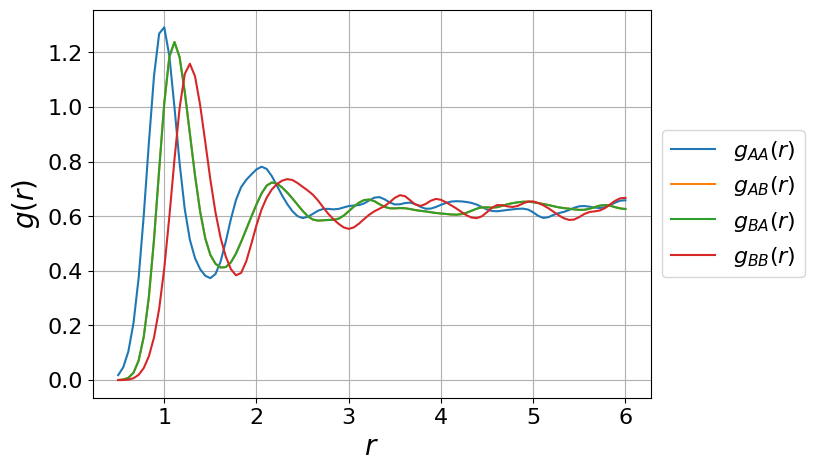

In [8]:
nbrs2 = neighbor_fn2.allocate(state.position)
gofr = gofr_fn(state.position, neighbor=nbrs2)

plt.plot(r, gofr[0][0], label = '$g_{AA}(r)$')
plt.plot(r, gofr[0][1], label = '$g_{AB}(r)$')
plt.plot(r, gofr[1][0], label = '$g_{BA}(r)$')
plt.plot(r, gofr[1][1], label = '$g_{BB}(r)$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
format_plot('$r$', '$g(r)$')
finalize_plot()

## Minimize the energy of the final state

In [9]:
R, max_grad, nbrs, niters = run_minimization_while_neighbor_list(
    energy_fn,
    neighbor_fn,
    state.position,
    shift,
    verbose=True)

renderer.render(
    box_size,
    {'particles': renderer.Disk(R, diameter=diameters, color=colors)},
    resolution=(512, 512)
)

Minimized the energy in 4 minimization loops (1000 steps each) and reached a final maximum gradient of 5.147965387308773e-14


### Stress and pressure

Notice, we do not pass the velocity now!

In [10]:
quantity.stress(energy_fn,
                R,
                box_size,
                neighbor=nbrs)

Array([[ 0.03190158, -0.00035302],
       [-0.00035302,  0.03174391]], dtype=float64)

In [11]:
quantity.pressure(energy_fn,
                  R,
                  box_size,
                  neighbor=nbrs)

Array(0.03182274, dtype=float64, weak_type=True)

### Pair correlation function

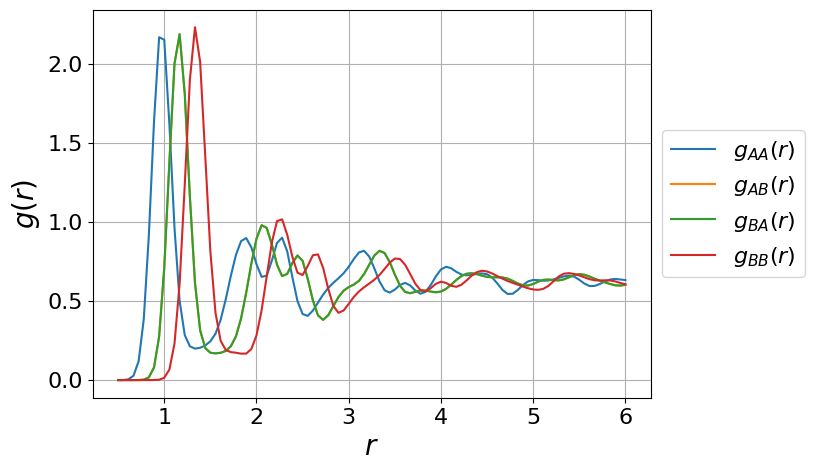

In [12]:
nbrs2 = nbrs2.update(R)
gofr = gofr_fn(R, neighbor=nbrs2)

plt.plot(r, gofr[0][0], label = '$g_{AA}(r)$')
plt.plot(r, gofr[0][1], label = '$g_{AB}(r)$')
plt.plot(r, gofr[1][0], label = '$g_{BA}(r)$')
plt.plot(r, gofr[1][1], label = '$g_{BB}(r)$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
format_plot('$r$', '$g(r)$')
finalize_plot()

### Deformations and linear elasticity

For speed reasons, lets switch to a smaller system.

We start by creating a $T=0$, mechanically stable system.

In [13]:
N_small = 64
dimension_small = 2

box_size_small = quantity.box_size_at_number_density(N_small, 1.2, dimension_small)
displacement_small, shift_small = space.periodic(box_size_small)

species_small = jnp.where(jnp.arange(N_small) < N // 2, 0, 1)
diameters_small = sigma.diagonal()[species_small]

energy_fn_small = energy.soft_sphere_pair(displacement_small, species=species_small, sigma=sigma)

R_init_small = random.uniform(key, (N_small,dimension_small), minval=0.0, maxval=box_size_small, dtype=f64)

R_small, max_grad, niters = run_minimization_while(energy_fn_small, R_init_small, shift_small)
print('Minimized the energy in {} minimization steps and reached a final \
maximum gradient of {}'.format(niters, max_grad))

Minimized the energy in 636 minimization steps and reached a final maximum gradient of 9.868510088967275e-13


Global deformations are defined by a strain tensor $\epsilon$, which transforms any vector $r$ according to
\begin{equation}
r \rightarrow (1 + \epsilon) \cdot r.
\end{equation}
Such a deformation can induce forces on particles, causing them to relax into a new mechanically stable configuration with a different energy.

Consider a shear deformation with magnitude $\gamma$:
$$
\epsilon = \gamma \left( \begin{matrix} 0&1\\1&0 \end{matrix} \right)
$$

First, let's calculate $\Delta U (\gamma) = U(\gamma) - U_0$.


In [14]:
# Define a unit strain tensor for shear
unit_strain_tensor = jnp.array([[0,1],[1,0]], dtype=jnp.float64)
print(unit_strain_tensor)

[[0. 1.]
 [1. 0.]]


In [15]:
# Define a function to calculate the energy at a given strain
@jit
def get_energy_at_strain(gamma):
  R_frac_coords = space.transform(space.inverse(box_size_small), R_small)
  new_box = jnp.matmul(jnp.eye(unit_strain_tensor.shape[0]) + gamma * unit_strain_tensor, box_size_small * jnp.eye(dimension_small))
  displacement_temp, shift_temp = space.periodic_general(new_box, fractional_coordinates=True)
  energy_fn_temp = energy.soft_sphere_pair(displacement_temp, species=species_small, sigma=sigma)
  R_final_temp, _, _ = run_minimization_while(energy_fn_temp, R_frac_coords, shift_temp)
  return energy_fn_temp(R_final_temp)

In [16]:
gammas = jnp.logspace(-7,-2,50)
U = jnp.array([get_energy_at_strain(gamma) for gamma in gammas])
print(U)

[0.14449171 0.14449171 0.14449171 0.14449171 0.14449171 0.14449171
 0.14449171 0.14449171 0.14449171 0.14449171 0.14449171 0.14449171
 0.14449171 0.14449171 0.14449171 0.14449171 0.14449171 0.14449171
 0.14449171 0.14449171 0.14449171 0.14449172 0.14449172 0.14449172
 0.14449173 0.14449173 0.14449174 0.14449176 0.14449177 0.1444918
 0.14449185 0.14449191 0.14449201 0.14449217 0.14449241 0.14449279
 0.14449338 0.14449431 0.14449579 0.14449814 0.14450193 0.14450866
 0.14452043 0.14454007 0.14457038 0.14461512 0.14437396 0.1442153
 0.14398351 0.14372142]


In [17]:
U = vmap(get_energy_at_strain)(gammas)
print(U)

[0.14449171 0.14449171 0.14449171 0.14449171 0.14449171 0.14449171
 0.14449171 0.14449171 0.14449171 0.14449171 0.14449171 0.14449171
 0.14449171 0.14449171 0.14449171 0.14449171 0.14449171 0.14449171
 0.14449171 0.14449171 0.14449171 0.14449172 0.14449172 0.14449172
 0.14449173 0.14449173 0.14449174 0.14449176 0.14449177 0.1444918
 0.14449185 0.14449191 0.14449201 0.14449217 0.14449241 0.14449279
 0.14449338 0.14449431 0.14449579 0.14449814 0.14450193 0.14450866
 0.14452043 0.14454007 0.14457038 0.14461512 0.14437396 0.1442153
 0.14398351 0.14372142]


**Use `vmap` to run parameter sweeps simultaneously over a gpu!**

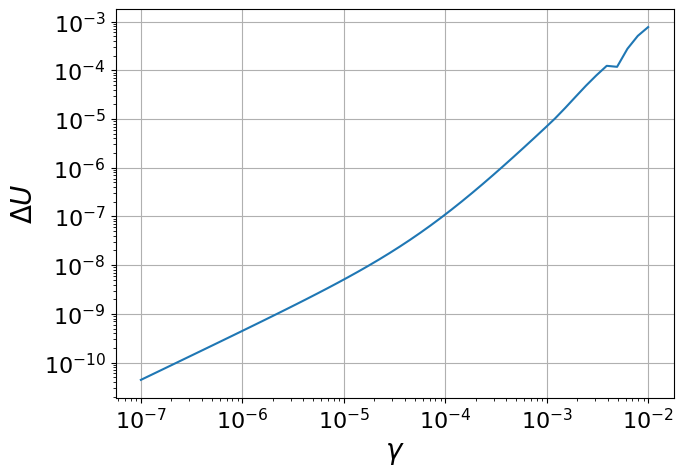

In [18]:
# Plot the change in energy as a functino of gamma
U_0 = energy_fn_small(R_small)
delta_U = U - U_0
plt.plot(gammas,jnp.abs(delta_U))
plt.xscale('log')
plt.yscale('log')
format_plot('$\gamma$', '$\Delta U$')
finalize_plot()

This change in energy can be written to lowest order as
\begin{equation}
\frac{ \Delta U}{V^0} = -\sigma^0_{ij}\epsilon_{ji} + O\left( \epsilon^2 \right)
\end{equation}
where $\sigma^0_{ij}$ is the stress tensor we already calculated.





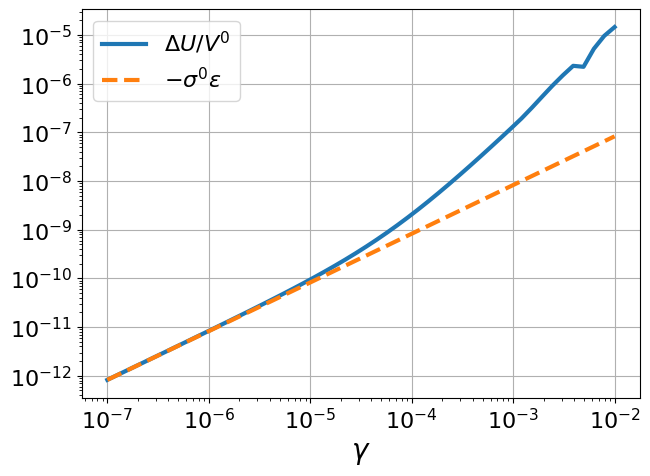

In [19]:
stress_0 = quantity.stress(energy_fn_small, R_small, box_size_small)
V_0 = quantity.volume(dimension_small, box_size_small)

y1 = delta_U / V_0
y2 = - gammas * jnp.einsum('ij,ji->',stress_0,unit_strain_tensor)
plt.plot(gammas, jnp.abs(y1), lw=3, label=r'$\Delta U/V^0$')
plt.plot(gammas, jnp.abs(y2), lw=3, ls='--', label=r'$-\sigma^0 \epsilon$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
format_plot('$\gamma$', '')
finalize_plot()

Clearly, the stress tensor is capturing the lowest order behavior correctly. However, these are not exactly the same:

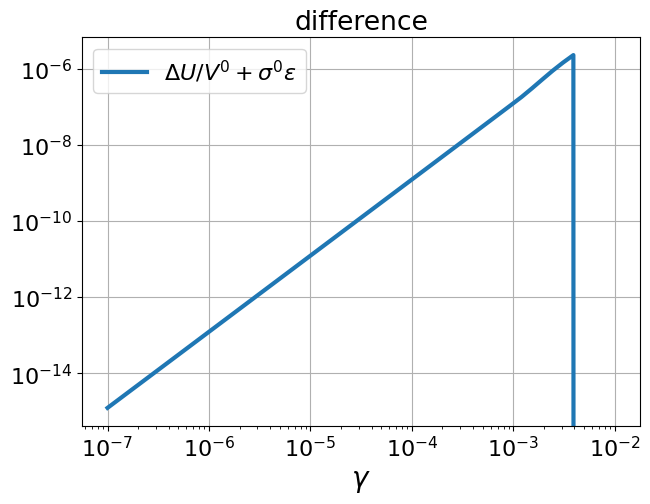

In [20]:
plt.plot(gammas, y1-y2, lw=3, label=r'$\Delta U/V^0 + \sigma^0 \epsilon$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('difference')
format_plot('$\gamma$', '')
finalize_plot()

The change in energy can be written to *quadratic* order as
\begin{equation}
\frac{ \Delta U}{V^0} = -\sigma^0_{ij}\epsilon_{ji} + \frac 12 C_{ijkl} \epsilon_{ij} \epsilon_{kl} + O\left( \epsilon^3 \right)
\end{equation}
where $C_{ijkl}$ is the $d × d × d × d$ elastic modulus tensor, which contains information like the bulk modulus, shear modulus, Youngs modulus, and Poisson's ratio.


We can calculate $C_{ijkl}$ using linear response theory, which is built in to JAX-MD.

In [21]:
emt_fn = jit(elasticity.athermal_moduli(energy_fn_small, check_convergence=True))
C, converged = emt_fn(R_small, box_size_small)
if not converged:
  print('WARNING: the internal solver did not converged. This could indicate \
  an error')

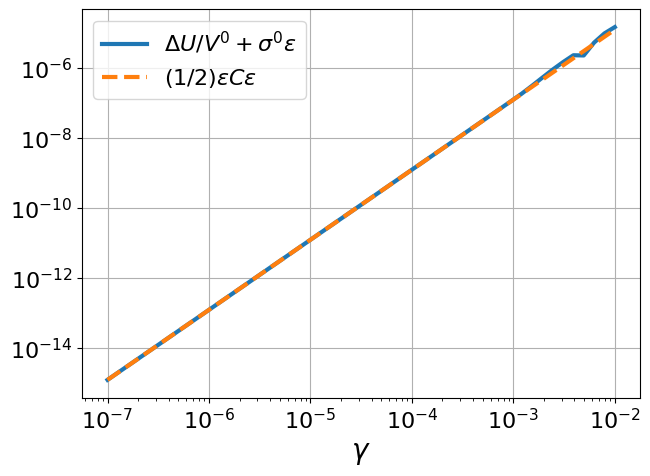

In [22]:
# Plot \Delta E/V - sigma*epsilon
y1 = delta_U / V_0 + gammas * jnp.einsum('ij,ji->',stress_0,unit_strain_tensor)
plt.plot(gammas, jnp.abs(y1), lw=3, label=r'$\Delta U/V^0 + \sigma^0 \epsilon$')

# Plot 0.5 * epsilon*C*epsilon
y2 = 0.5 * jnp.einsum('ij,ijkl,kl->',unit_strain_tensor, C, unit_strain_tensor) * gammas**2
plt.plot(gammas, jnp.abs(y2), ls='--', lw=3, label=r'$(1/2) \epsilon C \epsilon$')

plt.xscale('log')
plt.yscale('log')
plt.legend()
format_plot('$\gamma$','')
finalize_plot()

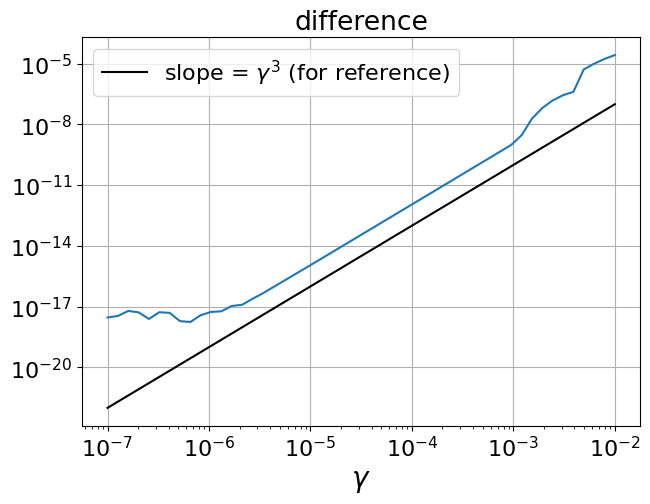

In [23]:
# Plot the difference, which should scales as gamma**3
plt.plot(gammas, jnp.abs(y1-y2))

# Plot gamma**3 for reference
plt.plot(gammas, 0.1*jnp.abs(gammas**3), 'black', label=r'slope = $\gamma^3$ (for reference)')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('difference')
format_plot('$\gamma$','')
finalize_plot()

If we assume the system to be isotropic, we can extract the bulk modulus, shear modulus, etc.

In [24]:
elasticity.extract_isotropic_moduli(C)

{'B': Array(0.67280598, dtype=float64),
 'G': Array(0.09237971, dtype=float64),
 'M': Array(0.76518569, dtype=float64),
 'E': Array(0.32490739, dtype=float64),
 'nu': Array(0.75854303, dtype=float64)}

## Custom Measurements

### Normal modes of vibration

Small vibrations about a local energy minimum can be calculated as a system of coupled harmonic oscillators, with the solution

\begin{equation}
a_m(t) = a_m(0) e^{i \sqrt{\lambda_m} t}
\end{equation}

where $a_m(t)$ is the projection of the perturbation at time $t$ onto the $m$-th eigenvector of the "dynamical matrix"

\begin{equation}
D_{ij}^{\alpha\beta} = \frac{1}{M_i M_j} \frac{d^2 U}{d r_i^\alpha d r_j^\beta},
\end{equation}
$\lambda_m$ is the corresponding eigenvalue, and $M_i$ the mass of particle $i$.

Therefore, we can calculate the density of vibrational modes by diagonalizing $D$.

In [25]:
H = hessian(energy_fn)(R, neighbor=nbrs)
D = hessian2dynamicalmatrix(H, masses, species, reshape=True)
evals, evecs = jnp.linalg.eigh(D)

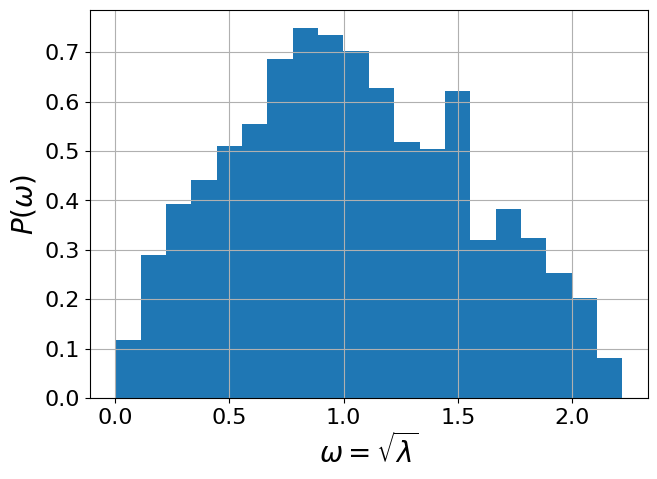

In [26]:
frequencies = jnp.sqrt(evals)
plt.hist(frequencies, 20, log=False, density=True)
format_plot('$\omega = \sqrt{\lambda}$','$P(\omega)$')
finalize_plot()

### Bond-orientational order parameters

The most common 2-dimensional bond-orientational order parameter is $\psi_6$:
\begin{equation}
\psi_6(i) = \frac 1{N_\mathrm{neighbors}} \sum_{j \in \mathrm{neighbors}} e^{i6\theta_{ij}}
\end{equation}

This complex number tells you the magnitude of (6-fold) order around particle $i$ and the orientation of that order.

We can rewrite this to not depend on knowledge of neighbors:
\begin{equation}
\psi_6(i) = \frac {\sum_{j \neq i} e^{i6\theta_{ij}} \; \Theta(r_\mathrm{threshold} - |r_{ij}|)}{\sum_{j \neq i} \Theta(r_\mathrm{threshold} - |r_{ij}|)}
\end{equation}

First, lets write a function that calculates $e^{i6\theta_{ij}} \; \Theta(r_\mathrm{threshold} - |r_{ij}|) $ given $|r_{ij}|$ and $\theta_{ij}$.

In [27]:
def psil_full_fn(dR, l=6, neighbor_threshold=1):
  """ Calculate the term in the sum

  Args:
    dR: array of shape (...,2) giving the vector displacement between
      particle pairs
    l:  integer giving the symmetry of the order parameter (usually 6)
    neighbor_threshold: cutoff for determining neighbors

  Return: complex array of shape (...) giving the order parameter for the
    particle pair
  """
  return jnp.where(
      jnp.linalg.norm(dR, axis=-1) < neighbor_threshold,
      jnp.exp(1j * l * jnp.apply_along_axis(lambda a: jnp.arctan2(a[1], a[0]),
                                            axis=-1,
                                            arr=dR)),
      0)

In [28]:
# 1. Calculate dR matrix
dR = space.map_product(displacement)(R,R)

# 2. Set a neighbor threshold matrix from the diameters
sigma_full = (jnp.vstack(diameters) + diameters)/2

# 3. Calculate psi6 for particle pairs
psi6_full = psil_full_fn(dR, l=6, neighbor_threshold=sigma_full)

In [29]:
psi6_full

Array([[1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 1.+0.j]],      dtype=complex128)

In [30]:
# NOTE: diagonal elements are 1 (not right)!
psi6_full.diagonal()

Array([1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
      

In [31]:
# 4. Mask the diagonal elements
psi6_full = smap._diagonal_mask(psi6_full)
psi6_full.diagonal()

Array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
      

In [32]:
# 5. Sum over every particle
psi6 = jnp.sum(psi6_full, axis=1)

# 6. Calculate number of neighbors for each particle
n_neighbors = jnp.sum(jnp.abs(psi6_full) > 1e-6, axis=1)

# 7. Divide
psi6 = psi6 / n_neighbors

psi6_version1 = psi6 #save for later comparison

In [39]:
def visualize_psi6(R, box_size, diameter, psi6, style):
  if style == 'magnitude':
    cm = plt.get_cmap('Greens')
    cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=1)
    data = jnp.abs(psi6)
  elif style == 'angle':
    cm = plt.get_cmap('hsv')
    cNorm  = matplotlib.colors.Normalize(vmin=-jnp.pi, vmax=jnp.pi)
    data = jnp.angle(psi6)
  else:
    assert False

  scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)
  colors = scalarMap.to_rgba(data)
  renderer.render(
      box_size,
      {'particles': renderer.Disk(R, diameter=diameter, color=colors[:,:3])},
      resolution=(512, 512)
  )

In [40]:
visualize_psi6(R, box_size, diameters, psi6, 'angle')

In [41]:
visualize_psi6(R, box_size, diameters, psi6, 'magnitude')

Redo for a polycrystal

In [42]:
#@title Run code to create and analyze polycrystal
def get_polycrystal(N = 1000):
  dimension = 2
  key = random.PRNGKey(0)

  box_size = quantity.box_size_at_number_density(N, 1.15, 2)
  displacement, shift = space.periodic(box_size)

  key, split = random.split(key)
  R_init = box_size * random.uniform(split, (N, dimension), dtype=jnp.float64)

  # The system ought to be a 50:50 mixture of two types of particles, one
  # large and one small.
  sigma = 1 #jnp.array([[1.0, 1.0], [1.01, 1.4]])
  diameters = jnp.full((N,), sigma)

  #energy_fn = energy.soft_sphere_pair(displacement, species=species, sigma=sigma)
  neighbor_fn, energy_fn = energy.soft_sphere_neighbor_list(
      displacement,
      box_size,
      sigma,
      dr_threshold=0.2,
      format=partition.Sparse)

  neighbor_fn = partition.neighbor_list(
    displacement,
    box_size,
    sigma,
    dr_threshold=0.4,
    capacity_multiplier = 2.2,
    format=partition.Sparse)

  nbrs_init = neighbor_fn.allocate(R_init)

  R, max_grad, nbrs, niters = run_minimization_while_neighbor_list(energy_fn, neighbor_fn, R_init, shift, verbose=True)

  def theta_function(dr, threshold):
    return jnp.where(dr < threshold, 1, 0)

  contact_nbr_list = smap.pair_neighbor_list(theta_function,
                                            space.canonicalize_displacement_or_metric(displacement),
                                            reduce_axis=(1,),
                                            threshold=sigma,
                                            )

  contact_nbr_list = jit(contact_nbr_list)

  n_neighbors = jnp.array(2*
                          contact_nbr_list(R, neighbor=nbrs)
                          , dtype=jnp.int16)

  psil_fn = smap.pair_neighbor_list(psil_full_fn,
                                    displacement,
                                    reduce_axis=(1,),
                                    l=6,
                                    neighbor_threshold=sigma)

  psil_fn = jit(psil_fn)

  psi6 = 2 * psil_fn(R, neighbor=nbrs) / n_neighbors

  return R, box_size, psi6

R_poly, box_size_poly, psi6_poly = get_polycrystal(N = 10000)

Minimized the energy in 12 minimization loops (1000 steps each) and reached a final maximum gradient of 2.620601218666918e-13


In [43]:
visualize_psi6(R_poly, box_size_poly, 1, psi6_poly, 'angle')

In [44]:
visualize_psi6(R_poly, box_size_poly, 1, psi6_poly, 'magnitude')

### There is a better way!

`smap.pair` and `smap.pair_neighbor_list` give a powerful interface for summing functions over neighbors. Let $F$ be a function that takes $r_{ij}$, which is either the distance between two particles or the vector displacement between two particles, and an optional set of parameters $\{p_{ij}\}$ that can depend on the particles. Common use cases are 1) to sum over all pairs of neighbors, i.e.

\begin{equation}f = w \sum_i \sum_{j \; nn.\; i} F(r_{ij}, \{p_{ij}\}) \end{equation}

with the weight $w=1/2$ to compensate for double-counting the $ij$ and $ji$ terms (which are often equal), and 2) for a given particle $i$, to sum over all of its neighbors, i.e.
\begin{equation}f_i = w_i \sum_{j \; nn.\; i} F(r_{ij}, \{p_{ij}\}). \end{equation}

The notation $j \; nn. \; i$ means all particles $j$ that are neighbors of $i$. The definition of neighbors is assumed to be incorporated into the definition of $F$, except that neighbor lists require a maximum threshold for determining neighbors.


**species**

**neighbor lists**

**masking diagonal elements**
*   maybe have the option of turning off `_diagonal_mask`

**summing**
*   `reduce_axis`
*   `keepdims`
*   the use of `high_precision_sum` (it would be nice if it cast to the highest precision but kept ints or complex numbers as ints/complexs.

**normalizations**
*   right now, sums are all divided by 2 to compensate for calculating both the $ij$ and the $ji$ terms. This is the right default behavior, but it would be nice if it could be adjusted manually. This would be useful for many per-particle quantities like order parameters, contact information, etc.

First, calculate the number of neighbors

\begin{equation}
N_\mathrm{neighbors}(i) = \sum_{j\neq i} \Theta(r_\mathrm{threshold} - |r_{ij}|)
\end{equation}

In [45]:
def theta_function(dr, threshold):
  return jnp.where(dr < threshold, 1, 0)

contact_pair = smap.pair(theta_function,
                         space.canonicalize_displacement_or_metric(displacement),
                         reduce_axis=(1,),
                         species=2)

n_neighbors = jnp.array(2*
                        contact_pair(R, species=species, threshold=sigma)
                        , dtype=jnp.int16)

print(n_neighbors[:20])

[5 5 4 3 4 3 4 5 4 5 5 5 4 5 5 5 5 5 5 5]


Now calculate $\psi_6(i)$

In [46]:
psil_fn = smap.pair(psil_full_fn,
                    displacement,
                    reduce_axis=(1,),
                    species=2)

psi6 = psil_fn(R, species=species, l=6, neighbor_threshold=sigma)
psi6 = 2 * psi6 / n_neighbors

In [47]:
print(jnp.allclose(psi6_version1, psi6))

True


Redo using neighbor lists

In [48]:
contact_nbr_list = smap.pair_neighbor_list(theta_function,
                                           space.canonicalize_displacement_or_metric(displacement),
                                           reduce_axis=(1,),
                                           species=species,
                                           threshold=sigma,
                                           )

n_neighbors = jnp.array(2*
                        contact_nbr_list(R, neighbor=nbrs)
                        , dtype=jnp.int16)

print(n_neighbors[:20])

[5 5 4 3 4 3 4 5 4 5 5 5 4 5 5 5 5 5 5 5]


In [49]:
psil_fn = smap.pair_neighbor_list(psil_full_fn,
                                  displacement,
                                  reduce_axis=(1,),
                                  species=species,
                                  l=6,
                                  neighbor_threshold=sigma)

psil_fn = jit(psil_fn)

psi6 = 2 * psil_fn(R, neighbor=nbrs) / n_neighbors

In [51]:
print(jnp.allclose(psi6_version1, psi6))

True
